In [1]:
import os, time, itertools
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import multiprocessing as mp
from copy import deepcopy
from pybaseball import *

/home/dcooper/anaconda3/envs/rockies/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Build expected outcomes tables at and not at Coor's Field

In [2]:
# Load/build database
if not os.path.exists('2020-2025_allBattedBallData.csv'):
    dfs = []
    for year in range(2020, 2026):
        print(f"Pulling {year}...")
        try:
            df = statcast(
                start_dt=f"{year}-03-01",
                end_dt=f"{year}-10-01",
                verbose=False
            )
            # Keep only balls in play
            df = df[df['type'] == 'X']
            dfs.append(df)
            time.sleep(5)  # be nice to Savant
        except Exception as e:
            print(f"Failed for {year}: {e}")
    
    all_bb_data = pd.concat(dfs, ignore_index=True)
    all_bb_data.to_csv('2020-2025_allBattedBallData.csv')
else:
    all_bb_data = pd.read_csv('2020-2025_allBattedBallData.csv', index_col=0)

# Filter to regular season games
all_bb_data = all_bb_data.loc[all_bb_data['game_type'] == 'R']

# Display dataframe
print(all_bb_data.shape)
all_bb_data.head()

(658753, 118)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
773,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,field_out,hit_into_play,...,NaN,1.38,0.86,-0.86,35.1,NaN,NaN,NaN,NaN,NaN
774,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,field_out,hit_into_play,...,NaN,1.25,0.92,-0.92,36.2,NaN,NaN,NaN,NaN,NaN
775,SI,2020-09-27,96.7,-2.20,5.92,"Cederlind, Blake",596019,664977,field_out,hit_into_play,...,2.0,1.92,1.44,-1.44,35.1,NaN,NaN,NaN,NaN,NaN
776,SI,2020-09-27,98.0,-2.19,5.94,"Cederlind, Blake",640458,664977,field_out,hit_into_play,...,3.0,1.82,1.38,1.38,34.1,NaN,NaN,NaN,NaN,NaN
777,FF,2020-09-27,91.3,2.59,5.99,"Hand, Brad",624428,543272,field_out,hit_into_play,...,NaN,1.37,1.09,1.09,27.2,NaN,NaN,NaN,NaN,NaN


In [3]:
# Set bins
ev_labels = np.array(['<80', '80-85', '85-90', '90-95', '95-100', '100-105', '105-110', '>=110'])
ev_bins = np.array([0,80,85,90,95,100,105,110,999])
la_labels = np.array(['<10°', '10-25°', '25-35°', '35-50°', '>=50°'])
la_bins = np.array([-999, 10, 25, 35, 50, 999])
sa_labels = np.array(['-45 to -27°', '-27 to -9°', '-9 to 9°', '9 to 27°', '27 to 45°'])
sa_bins = np.array([-999, -27,  -9,  9,  27, 999])

# Add spray angle column
all_bb_data.insert(0, 'spray_angle', value=np.degrees(np.arctan2(all_bb_data['hc_x'] - 125, 199 - all_bb_data['hc_y'])), allow_duplicates=False)

# Add bin columns 
all_bb_data.insert(0, 'launch_speed_bin', value='', allow_duplicates=False)
all_bb_data.insert(0, 'launch_angle_bin', value='', allow_duplicates=False)
all_bb_data.insert(0, 'spray_angle_bin', value='', allow_duplicates=False)

# Reorder columns
tgt_cols = ['launch_speed', 'launch_speed_bin', 'launch_angle', 'launch_angle_bin', 'spray_angle', 'spray_angle_bin', 'events', 'home_team', 'hc_x', 'hc_y', 'stand'] 
df = all_bb_data[tgt_cols]

# Add data to new columns
df.loc[:,'launch_speed_bin'] = pd.cut(df['launch_speed'], ev_bins, labels=ev_labels, right=False)
df.loc[:,'launch_angle_bin'] = pd.cut(df['launch_angle'], la_bins, labels=la_labels, right=False)
df.loc[:,'spray_angle_bin'] = pd.cut(df['spray_angle'], sa_bins, labels=sa_labels, right=False)

df.head()

,launch_speed,launch_speed_bin,launch_angle,launch_angle_bin,spray_angle,spray_angle_bin,events,home_team,hc_x,hc_y,stand
773,88.4,85-90,32.0,25-35°,43.763679,27 to 45°,field_out,CLE,217.94,101.96,R
774,102.0,100-105,41.0,35-50°,-5.926369,-9 to 9°,field_out,CLE,108.85,43.42,R
775,100.5,100-105,-20.0,<10°,24.128726,9 to 27°,field_out,CLE,152.61,137.36,L
776,84.1,80-85,22.0,10-25°,-19.733931,-27 to -9°,field_out,CLE,81.95,78.99,R
777,88.7,85-90,17.0,10-25°,-26.614826,-27 to -9°,field_out,CLE,76.57,102.35,L


In [4]:
# Build expected outcomes table
exp_outcomes = pd.DataFrame(columns=['EV', 'LA', 'SA', 'ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'Bases_nCoors', 'Bases_Coors', 'n_Coors'])

# Check for valid events
valid_events = [
    'home_run', 'triple', 'double', 'single',
    'field_out', 'sac_fly', 'force_out',
    'double_play', 'grounded_into_double_play',
    'fielders_choice_out', 'fielders_choice',
    'triple_play', 'sac_fly_double_play'
]
df = df.loc[df['events'].isin(valid_events)]

# Iterate through bin type combinations
for ev_bin, la_bin, sa_bin in itertools.product(ev_labels, la_labels, sa_labels):

    # Filter by bin types
    bin_df = df.loc[df['launch_speed_bin'] == ev_bin]
    bin_df = bin_df.loc[bin_df['launch_angle_bin'] == la_bin]
    bin_df = bin_df.loc[bin_df['spray_angle_bin'] == sa_bin]

    # Split by location
    c_bin_df = bin_df.loc[bin_df['home_team'] == 'COL']
    nc_bin_df = bin_df.loc[bin_df['home_team'] != 'COL']

    # Iterate through outcomes and compute deltas for hits
    nc = []
    c = []
    deltas = []
    for event in ['home_run', 'triple', 'double', 'single', 'out']:

        # Get event occurance
        if event == 'out':
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
        else:
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'] == event].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'] == event].shape[0]

        # Convert to probabilities
        try:
            nc_p_event = nc_n_event / nc_bin_df.shape[0]
            c_p_event = c_n_event / c_bin_df.shape[0]
        except ZeroDivisionError:
            deltas.append(np.nan)
            nc.append(np.nan)
            c.append(np.nan)
            continue

        # Compute delta probabilities
        d_p_event = c_p_event - nc_p_event
        deltas.append(d_p_event)
        nc.append(nc_p_event)
        c.append(c_p_event)

    nc_bases = 4 * nc[0] + 3 * nc[1] + 2 * nc[2] + nc[1]
    c_bases = 4 * c[0] + 3 * c[1] + 2 * c[2] + c[1]
    exp_outcomes.loc[exp_outcomes.shape[0]] = [ev_bin, la_bin, sa_bin]  + deltas + [nc_bases, c_bases] + [c_bin_df.shape[0]]

# Drop NA
exp_outcomes.dropna(inplace=True)

# Drop anywhere n_Coors < 50
exp_outcomes = exp_outcomes.loc[exp_outcomes['n_Coors'] >= 50]

# Add delta bases
d_bases = 4 * exp_outcomes['ΔHR'] + 3 * exp_outcomes['Δ3B'] + 2 * exp_outcomes['Δ2B'] + exp_outcomes['Δ1B']
exp_outcomes.insert(10, 'ΔBases', d_bases)

# Round 
exp_outcomes = exp_outcomes.round(2)

## Visualize dataframes

In [5]:
# Method for visualizaed dataframes
def plot_df(df, title, nrows=10, ascending=False):
    styled_df = df.sort_values(title, ascending=ascending).head(nrows)
    styled_df = styled_df.style.background_gradient(
        cmap='bwr', 
        vmin=-1, 
        vmax=1, 
        subset=['ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'ΔBases']
    ).background_gradient(
        cmap='bwr', 
        vmin=0, 
        vmax=4, 
        subset=['Bases_nCoors', 'Bases_Coors']
    ).set_caption(title)

    display(styled_df)

# Sort by delta home runs
plot_df(exp_outcomes, 'ΔBases')
plot_df(exp_outcomes, 'Bases_nCoors')
plot_df(exp_outcomes, 'Bases_Coors')
plot_df(exp_outcomes, 'ΔHR')
plot_df(exp_outcomes, 'Δ3B')
plot_df(exp_outcomes, 'Δ2B')
plot_df(exp_outcomes, 'Δ1B')
plot_df(exp_outcomes, 'ΔOut')
plot_df(exp_outcomes, 'ΔOut', ascending=True)

,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
115,95-100,35-50°,-45 to -27°,0.290000,-0.000000,-0.030000,-0.000000,-0.250000,0.890000,1.960000,1.070000,57
110,95-100,25-35°,-45 to -27°,0.260000,0.000000,-0.020000,-0.010000,-0.230000,2.030000,3.030000,0.990000,103
113,95-100,25-35°,9 to 27°,0.060000,0.030000,0.220000,-0.010000,-0.310000,0.770000,1.580000,0.770000,156
137,100-105,25-35°,-9 to 9°,0.130000,0.030000,0.060000,-0.000000,-0.220000,1.220000,2.000000,0.740000,131
138,100-105,25-35°,9 to 27°,0.120000,0.030000,0.060000,-0.000000,-0.210000,2.520000,3.220000,0.670000,108
162,105-110,25-35°,-9 to 9°,0.120000,-0.000000,0.020000,-0.000000,-0.130000,3.150000,3.660000,0.510000,53
141,100-105,35-50°,-27 to -9°,0.090000,-0.000000,0.040000,-0.000000,-0.120000,0.820000,1.250000,0.430000,72
114,95-100,25-35°,27 to 45°,-0.040000,0.080000,0.180000,-0.010000,-0.200000,1.840000,2.330000,0.400000,102
119,95-100,35-50°,27 to 45°,0.060000,0.070000,-0.020000,-0.000000,-0.100000,0.790000,1.250000,0.390000,61
89,90-95,25-35°,27 to 45°,-0.020000,0.030000,0.140000,0.010000,-0.160000,0.560000,0.860000,0.290000,109


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
161,105-110,25-35°,-27 to -9°,-0.060000,0.020000,0.050000,0.000000,-0.020000,3.820000,3.780000,-0.060000,54
135,100-105,25-35°,-45 to -27°,0.090000,0.010000,-0.050000,-0.000000,-0.050000,3.640000,3.950000,0.290000,75
139,100-105,25-35°,27 to 45°,0.040000,0.020000,0.020000,-0.010000,-0.070000,3.500000,3.790000,0.260000,66
162,105-110,25-35°,-9 to 9°,0.120000,-0.000000,0.020000,-0.000000,-0.130000,3.150000,3.660000,0.510000,53
136,100-105,25-35°,-27 to -9°,-0.040000,0.040000,0.130000,-0.000000,-0.120000,2.800000,3.040000,0.190000,114
138,100-105,25-35°,9 to 27°,0.120000,0.030000,0.060000,-0.000000,-0.210000,2.520000,3.220000,0.670000,108
110,95-100,25-35°,-45 to -27°,0.260000,0.000000,-0.020000,-0.010000,-0.230000,2.030000,3.030000,0.990000,103
114,95-100,25-35°,27 to 45°,-0.040000,0.080000,0.180000,-0.010000,-0.200000,1.840000,2.330000,0.400000,102
155,105-110,10-25°,-45 to -27°,0.020000,-0.000000,-0.030000,0.040000,-0.020000,1.650000,1.640000,0.030000,133
156,105-110,10-25°,-27 to -9°,-0.060000,0.060000,0.060000,-0.020000,-0.040000,1.620000,1.740000,0.040000,146


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
135,100-105,25-35°,-45 to -27°,0.090000,0.010000,-0.050000,-0.000000,-0.050000,3.640000,3.950000,0.290000,75
139,100-105,25-35°,27 to 45°,0.040000,0.020000,0.020000,-0.010000,-0.070000,3.500000,3.790000,0.260000,66
161,105-110,25-35°,-27 to -9°,-0.060000,0.020000,0.050000,0.000000,-0.020000,3.820000,3.780000,-0.060000,54
162,105-110,25-35°,-9 to 9°,0.120000,-0.000000,0.020000,-0.000000,-0.130000,3.150000,3.660000,0.510000,53
138,100-105,25-35°,9 to 27°,0.120000,0.030000,0.060000,-0.000000,-0.210000,2.520000,3.220000,0.670000,108
136,100-105,25-35°,-27 to -9°,-0.040000,0.040000,0.130000,-0.000000,-0.120000,2.800000,3.040000,0.190000,114
110,95-100,25-35°,-45 to -27°,0.260000,0.000000,-0.020000,-0.010000,-0.230000,2.030000,3.030000,0.990000,103
114,95-100,25-35°,27 to 45°,-0.040000,0.080000,0.180000,-0.010000,-0.200000,1.840000,2.330000,0.400000,102
137,100-105,25-35°,-9 to 9°,0.130000,0.030000,0.060000,-0.000000,-0.220000,1.220000,2.000000,0.740000,131
115,95-100,35-50°,-45 to -27°,0.290000,-0.000000,-0.030000,-0.000000,-0.250000,0.890000,1.960000,1.070000,57


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
115,95-100,35-50°,-45 to -27°,0.290000,-0.000000,-0.030000,-0.000000,-0.250000,0.890000,1.960000,1.070000,57
110,95-100,25-35°,-45 to -27°,0.260000,0.000000,-0.020000,-0.010000,-0.230000,2.030000,3.030000,0.990000,103
137,100-105,25-35°,-9 to 9°,0.130000,0.030000,0.060000,-0.000000,-0.220000,1.220000,2.000000,0.740000,131
138,100-105,25-35°,9 to 27°,0.120000,0.030000,0.060000,-0.000000,-0.210000,2.520000,3.220000,0.670000,108
162,105-110,25-35°,-9 to 9°,0.120000,-0.000000,0.020000,-0.000000,-0.130000,3.150000,3.660000,0.510000,53
135,100-105,25-35°,-45 to -27°,0.090000,0.010000,-0.050000,-0.000000,-0.050000,3.640000,3.950000,0.290000,75
141,100-105,35-50°,-27 to -9°,0.090000,-0.000000,0.040000,-0.000000,-0.120000,0.820000,1.250000,0.430000,72
85,90-95,25-35°,-45 to -27°,0.080000,-0.010000,-0.080000,-0.010000,0.010000,0.640000,0.780000,0.130000,80
119,95-100,35-50°,27 to 45°,0.060000,0.070000,-0.020000,-0.000000,-0.100000,0.790000,1.250000,0.390000,61
113,95-100,25-35°,9 to 27°,0.060000,0.030000,0.220000,-0.010000,-0.310000,0.770000,1.580000,0.770000,156


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
114,95-100,25-35°,27 to 45°,-0.040000,0.080000,0.180000,-0.010000,-0.200000,1.840000,2.330000,0.400000,102
34,80-85,10-25°,27 to 45°,0.000000,0.080000,-0.080000,0.040000,-0.040000,0.400000,0.560000,0.120000,82
119,95-100,35-50°,27 to 45°,0.060000,0.070000,-0.020000,-0.000000,-0.100000,0.790000,1.250000,0.390000,61
156,105-110,10-25°,-27 to -9°,-0.060000,0.060000,0.060000,-0.020000,-0.040000,1.620000,1.740000,0.040000,146
88,90-95,25-35°,9 to 27°,-0.000000,0.050000,0.060000,0.010000,-0.110000,0.120000,0.420000,0.260000,104
112,95-100,25-35°,-9 to 9°,0.000000,0.040000,0.010000,-0.000000,-0.050000,0.110000,0.290000,0.140000,143
59,85-90,10-25°,27 to 45°,0.000000,0.040000,-0.050000,0.000000,0.010000,0.420000,0.480000,0.020000,129
136,100-105,25-35°,-27 to -9°,-0.040000,0.040000,0.130000,-0.000000,-0.120000,2.800000,3.040000,0.190000,114
131,100-105,10-25°,-27 to -9°,-0.030000,0.030000,0.090000,-0.040000,-0.060000,1.060000,1.260000,0.130000,234
106,95-100,10-25°,-27 to -9°,-0.010000,0.030000,0.030000,-0.000000,-0.040000,0.500000,0.650000,0.110000,204


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
113,95-100,25-35°,9 to 27°,0.060000,0.030000,0.220000,-0.010000,-0.310000,0.770000,1.580000,0.770000,156
114,95-100,25-35°,27 to 45°,-0.040000,0.080000,0.180000,-0.010000,-0.200000,1.840000,2.330000,0.400000,102
89,90-95,25-35°,27 to 45°,-0.020000,0.030000,0.140000,0.010000,-0.160000,0.560000,0.860000,0.290000,109
136,100-105,25-35°,-27 to -9°,-0.040000,0.040000,0.130000,-0.000000,-0.120000,2.800000,3.040000,0.190000,114
111,95-100,25-35°,-27 to -9°,-0.010000,0.020000,0.100000,0.010000,-0.120000,0.970000,1.200000,0.220000,120
131,100-105,10-25°,-27 to -9°,-0.030000,0.030000,0.090000,-0.040000,-0.060000,1.060000,1.260000,0.130000,234
159,105-110,10-25°,27 to 45°,-0.030000,0.020000,0.090000,-0.080000,0.000000,1.480000,1.610000,0.040000,93
133,100-105,10-25°,9 to 27°,-0.030000,0.030000,0.080000,-0.030000,-0.040000,1.000000,1.140000,0.080000,265
108,95-100,10-25°,9 to 27°,-0.000000,0.000000,0.070000,-0.050000,-0.020000,0.470000,0.610000,0.090000,198
10,<80,25-35°,-45 to -27°,0.000000,-0.000000,0.060000,-0.030000,-0.020000,0.280000,0.390000,0.080000,72


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
18,<80,35-50°,9 to 27°,0.000000,0.000000,-0.010000,0.140000,-0.130000,0.030000,0.000000,0.110000,109
16,<80,35-50°,-27 to -9°,0.000000,0.010000,0.000000,0.120000,-0.130000,0.030000,0.070000,0.150000,108
11,<80,25-35°,-27 to -9°,0.000000,-0.000000,0.010000,0.110000,-0.120000,0.040000,0.060000,0.140000,98
13,<80,25-35°,9 to 27°,0.000000,-0.000000,0.000000,0.110000,-0.110000,0.020000,0.020000,0.110000,105
15,<80,35-50°,-45 to -27°,0.000000,-0.000000,-0.020000,0.100000,-0.080000,0.170000,0.120000,0.050000,101
80,90-95,10-25°,-45 to -27°,-0.000000,-0.010000,-0.060000,0.100000,-0.030000,0.580000,0.420000,-0.050000,109
104,95-100,<10°,27 to 45°,0.000000,0.010000,-0.010000,0.100000,-0.090000,0.130000,0.130000,0.090000,381
32,80-85,10-25°,-9 to 9°,0.000000,-0.000000,0.010000,0.090000,-0.100000,0.020000,0.040000,0.110000,92
7,<80,10-25°,-9 to 9°,0.000000,-0.000000,-0.000000,0.080000,-0.080000,0.000000,0.000000,0.080000,183
55,85-90,10-25°,-45 to -27°,0.000000,0.010000,0.010000,0.070000,-0.090000,0.490000,0.550000,0.120000,123


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
60,85-90,25-35°,-45 to -27°,-0.000000,-0.010000,-0.070000,0.010000,0.070000,0.270000,0.100000,-0.160000,61
57,85-90,10-25°,-9 to 9°,-0.000000,-0.000000,-0.010000,-0.050000,0.060000,0.030000,0.000000,-0.080000,119
25,80-85,<10°,-45 to -27°,0.000000,-0.000000,-0.010000,-0.040000,0.050000,0.090000,0.060000,-0.070000,226
27,80-85,<10°,-9 to 9°,0.000000,0.000000,-0.000000,-0.040000,0.040000,0.000000,0.000000,-0.050000,95
125,100-105,<10°,-45 to -27°,0.000000,0.000000,-0.020000,-0.020000,0.040000,0.270000,0.240000,-0.050000,304
28,80-85,<10°,9 to 27°,0.000000,0.000000,-0.000000,-0.030000,0.030000,0.000000,0.000000,-0.040000,145
39,80-85,25-35°,27 to 45°,0.000000,-0.020000,0.010000,-0.030000,0.030000,0.210000,0.160000,-0.060000,50
19,<80,35-50°,27 to 45°,0.000000,0.000000,-0.000000,-0.030000,0.030000,0.120000,0.140000,-0.020000,130
9,<80,10-25°,27 to 45°,0.000000,0.000000,0.030000,-0.060000,0.030000,0.200000,0.270000,0.010000,156
107,95-100,10-25°,-9 to 9°,-0.000000,-0.000000,0.010000,-0.030000,0.030000,0.100000,0.100000,-0.030000,228


,EV,LA,SA,ΔHR,Δ3B,Δ2B,Δ1B,ΔOut,Bases_nCoors,Bases_Coors,ΔBases,n_Coors
113,95-100,25-35°,9 to 27°,0.060000,0.030000,0.220000,-0.010000,-0.310000,0.770000,1.580000,0.770000,156
115,95-100,35-50°,-45 to -27°,0.290000,-0.000000,-0.030000,-0.000000,-0.250000,0.890000,1.960000,1.070000,57
110,95-100,25-35°,-45 to -27°,0.260000,0.000000,-0.020000,-0.010000,-0.230000,2.030000,3.030000,0.990000,103
137,100-105,25-35°,-9 to 9°,0.130000,0.030000,0.060000,-0.000000,-0.220000,1.220000,2.000000,0.740000,131
138,100-105,25-35°,9 to 27°,0.120000,0.030000,0.060000,-0.000000,-0.210000,2.520000,3.220000,0.670000,108
114,95-100,25-35°,27 to 45°,-0.040000,0.080000,0.180000,-0.010000,-0.200000,1.840000,2.330000,0.400000,102
89,90-95,25-35°,27 to 45°,-0.020000,0.030000,0.140000,0.010000,-0.160000,0.560000,0.860000,0.290000,109
18,<80,35-50°,9 to 27°,0.000000,0.000000,-0.010000,0.140000,-0.130000,0.030000,0.000000,0.110000,109
16,<80,35-50°,-27 to -9°,0.000000,0.010000,0.000000,0.120000,-0.130000,0.030000,0.070000,0.150000,108
162,105-110,25-35°,-9 to 9°,0.120000,-0.000000,0.020000,-0.000000,-0.130000,3.150000,3.660000,0.510000,53


## Plot spray charts

In [6]:
# Methods to plot spray chart
def draw_field(ax, r=415):
    theta = np.linspace(-np.pi/4, np.pi/4, 200)
    ax.plot(r*np.sin(theta), r*np.cos(theta), color='black', lw=1)
    ax.plot(154*np.sin(theta), 154*np.cos(theta), color='black', lw=1)
    ax.plot([0, -r/np.sqrt(2)], [0, r/np.sqrt(2)], color='black', lw=1)
    ax.plot([0, r/np.sqrt(2)], [0, r/np.sqrt(2)], color='black', lw=1)
    ax.scatter(0, 0, color='black', s=20)  # home plate

    return ax

def draw_wedge(ax, range: tuple=(-45,45), val=1, norm_factor=1, r=415):
    from matplotlib.patches import Wedge

    theta1 = 90 - range[0] 
    theta2 = 90 - range[1]
    alpha = np.abs(val) / norm_factor
    if val > 0:
        color = 'red'
    else:
        color = 'blue'
    
    wedge = Wedge(
        center=(0,0),
        r=r,
        theta1=theta2,
        theta2=theta1,
        facecolor=color,
        alpha=alpha
    )
    ax.add_patch(wedge)
    return ax

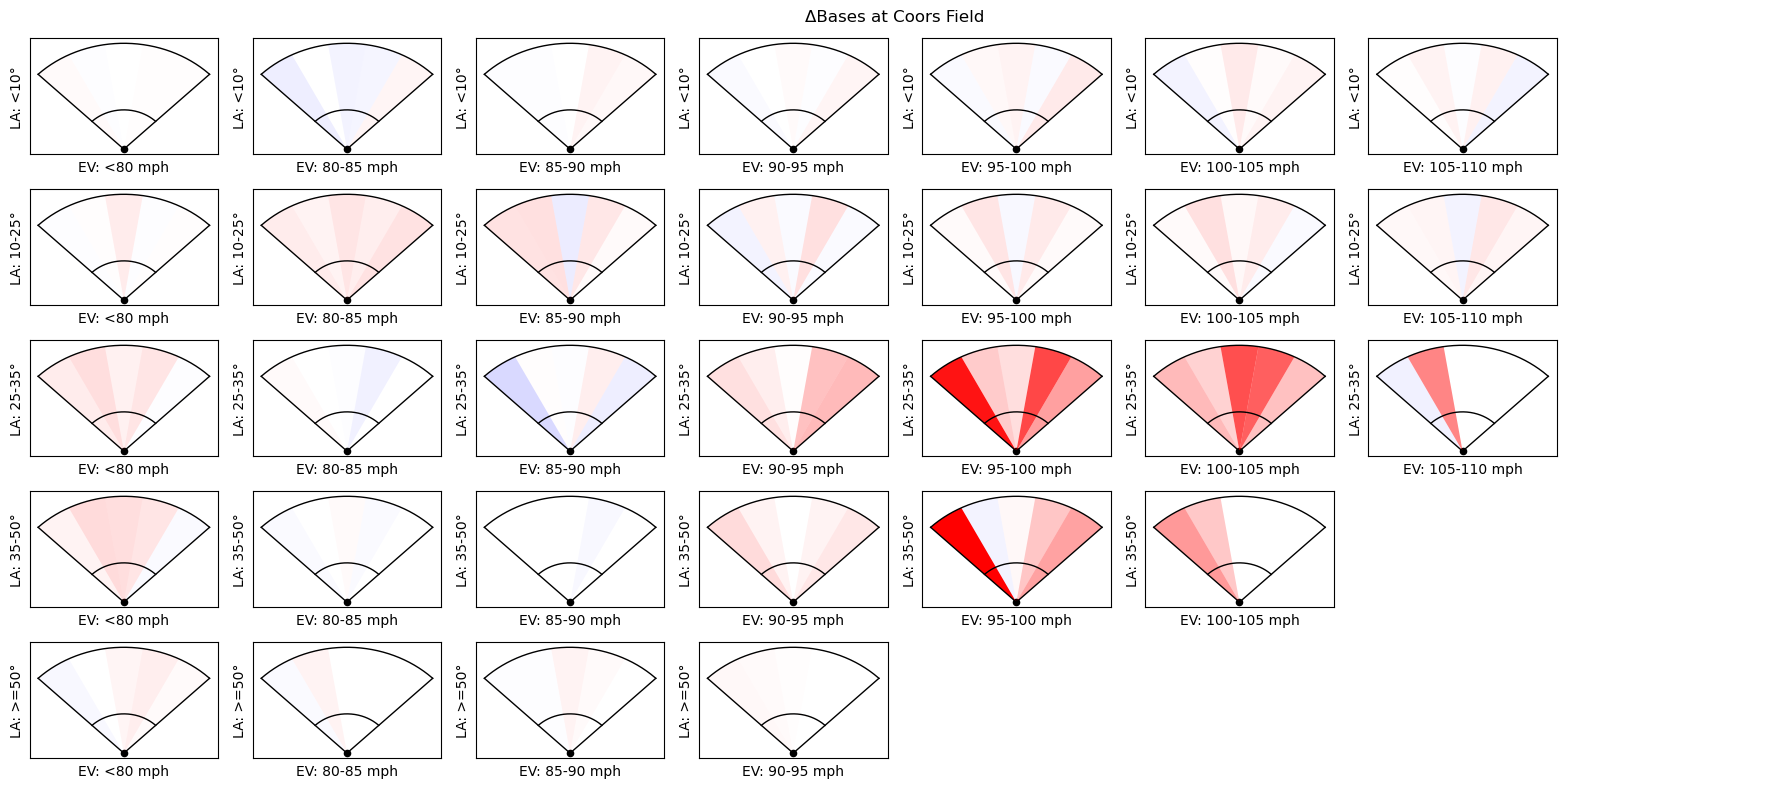

In [7]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['ΔBases'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB, norm_factor=max(np.abs(exp_outcomes['ΔBases']).max(), 1))

fig.suptitle('ΔBases at Coors Field')
fig.tight_layout()
plt.show()

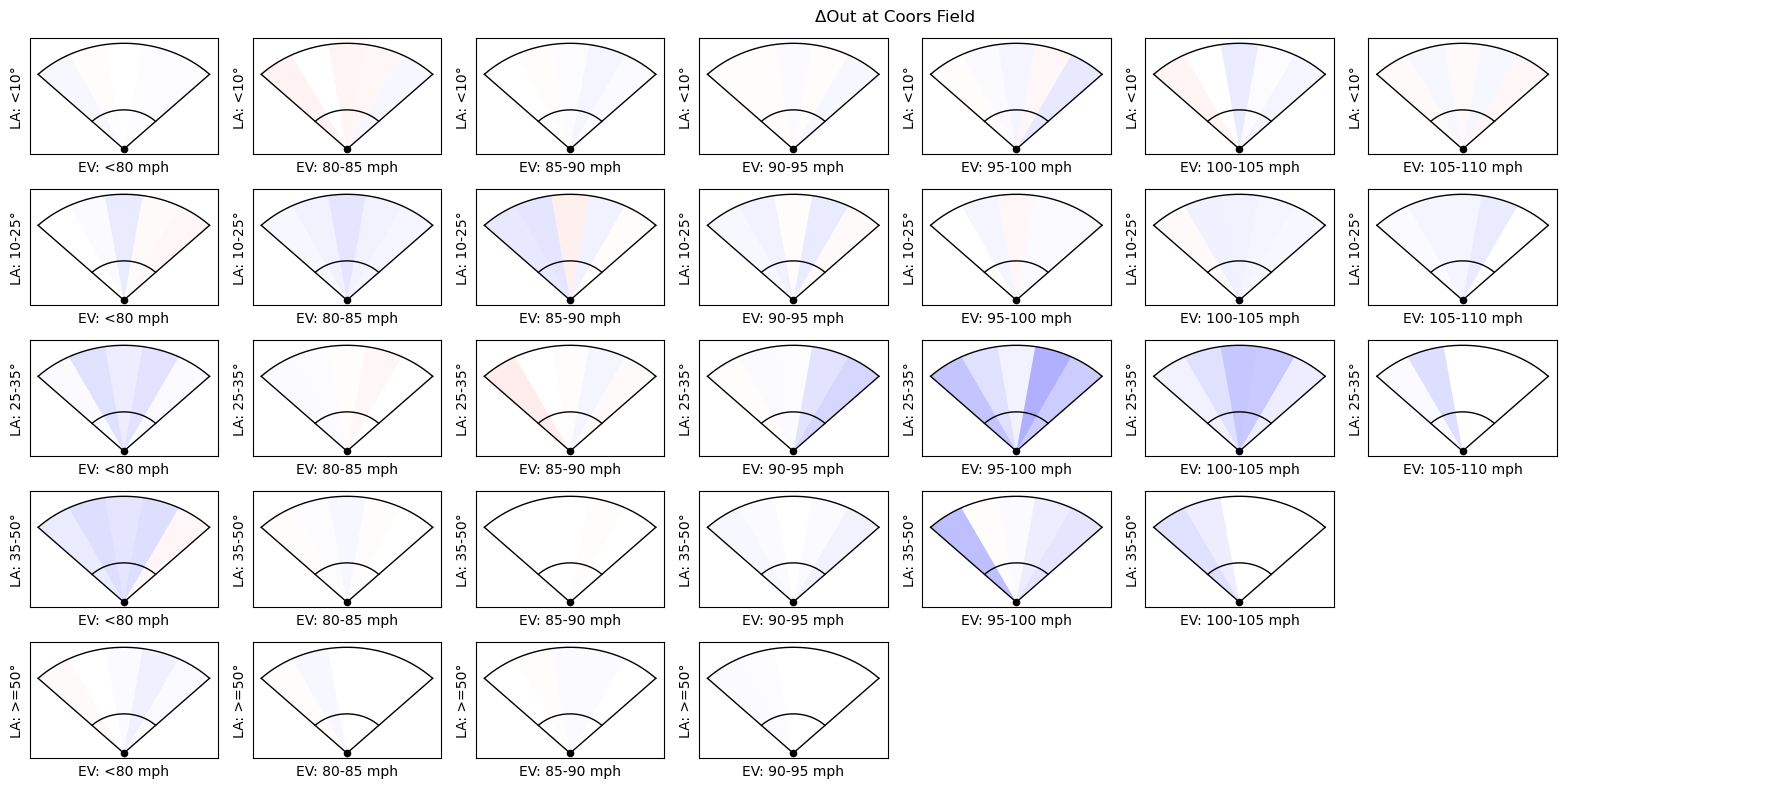

In [8]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['ΔOut'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB)

fig.suptitle('ΔOut at Coors Field')
fig.tight_layout()
plt.show()

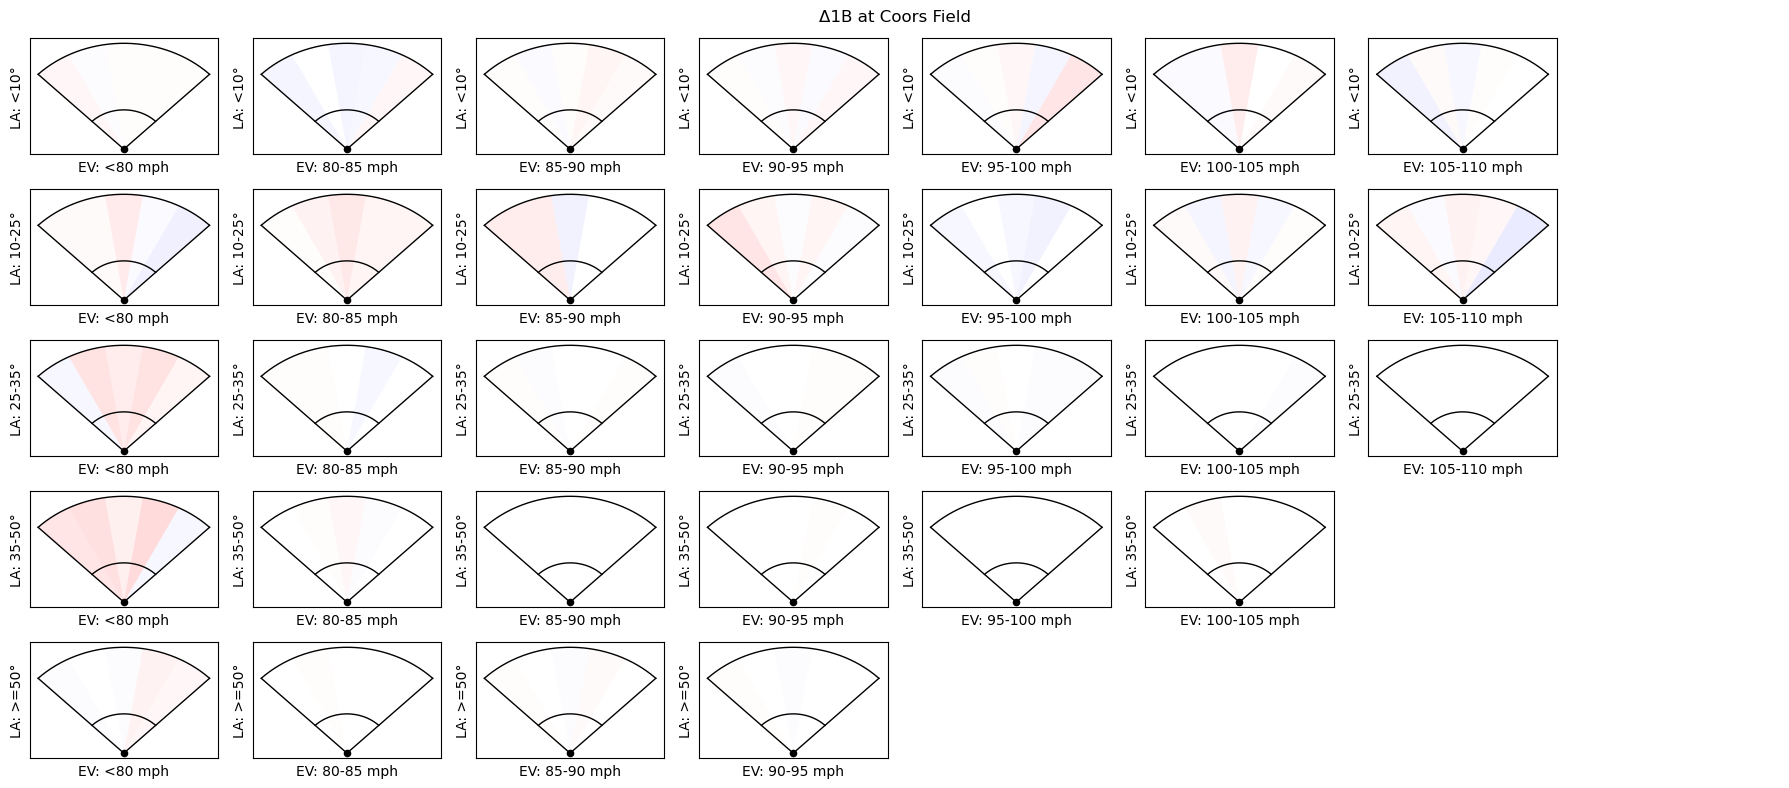

In [9]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['Δ1B'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB)

fig.suptitle('Δ1B at Coors Field')
fig.tight_layout()
plt.show()

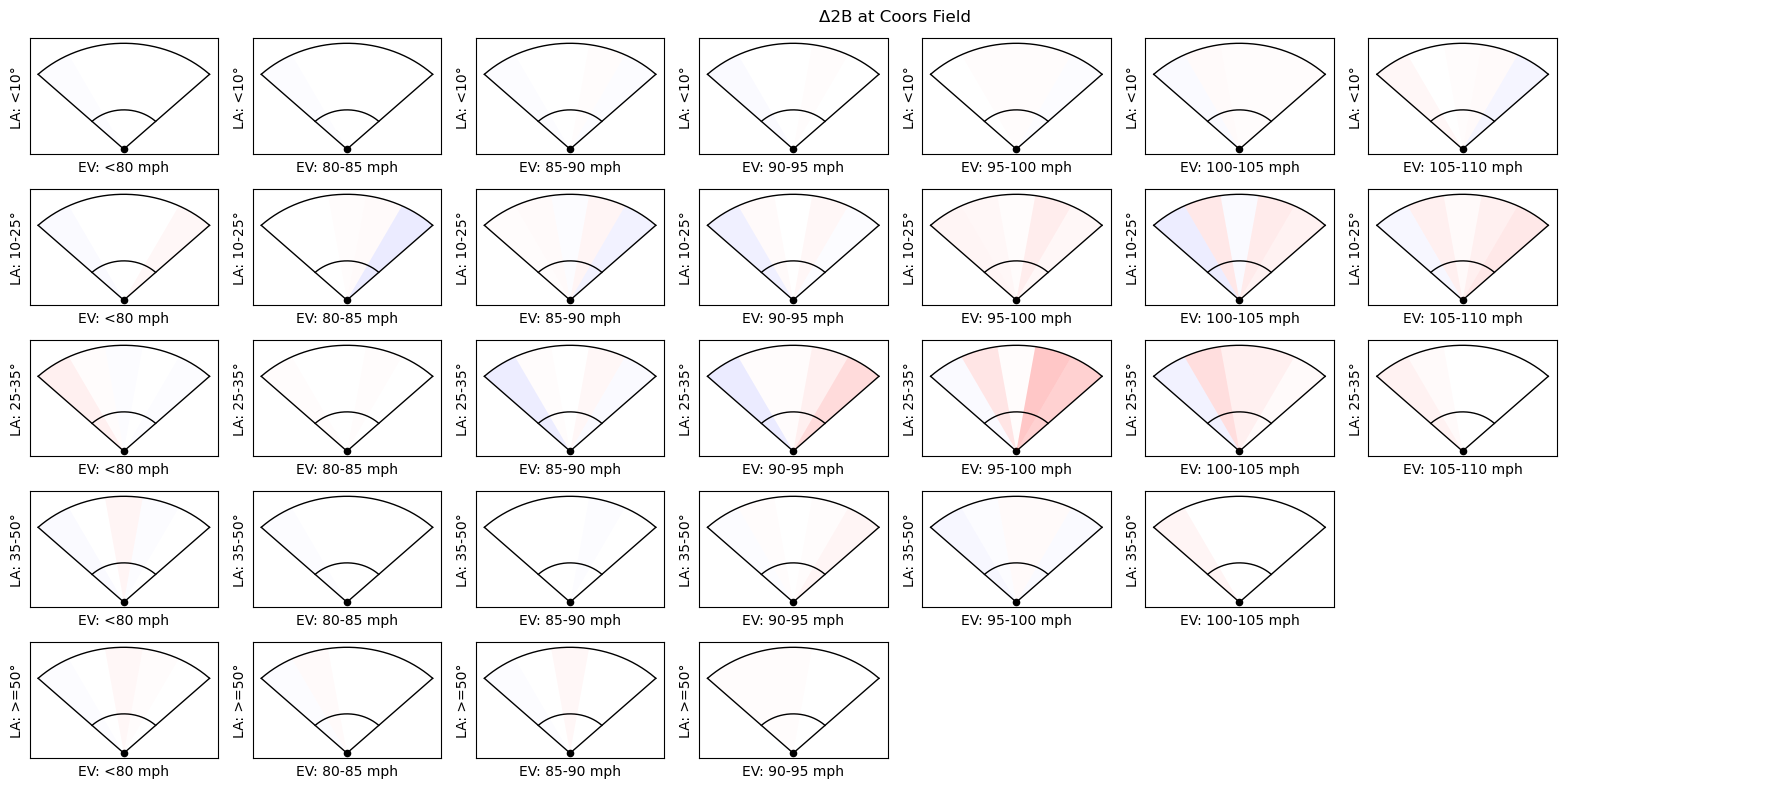

In [10]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['Δ2B'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB)

fig.suptitle('Δ2B at Coors Field')
fig.tight_layout()
plt.show()

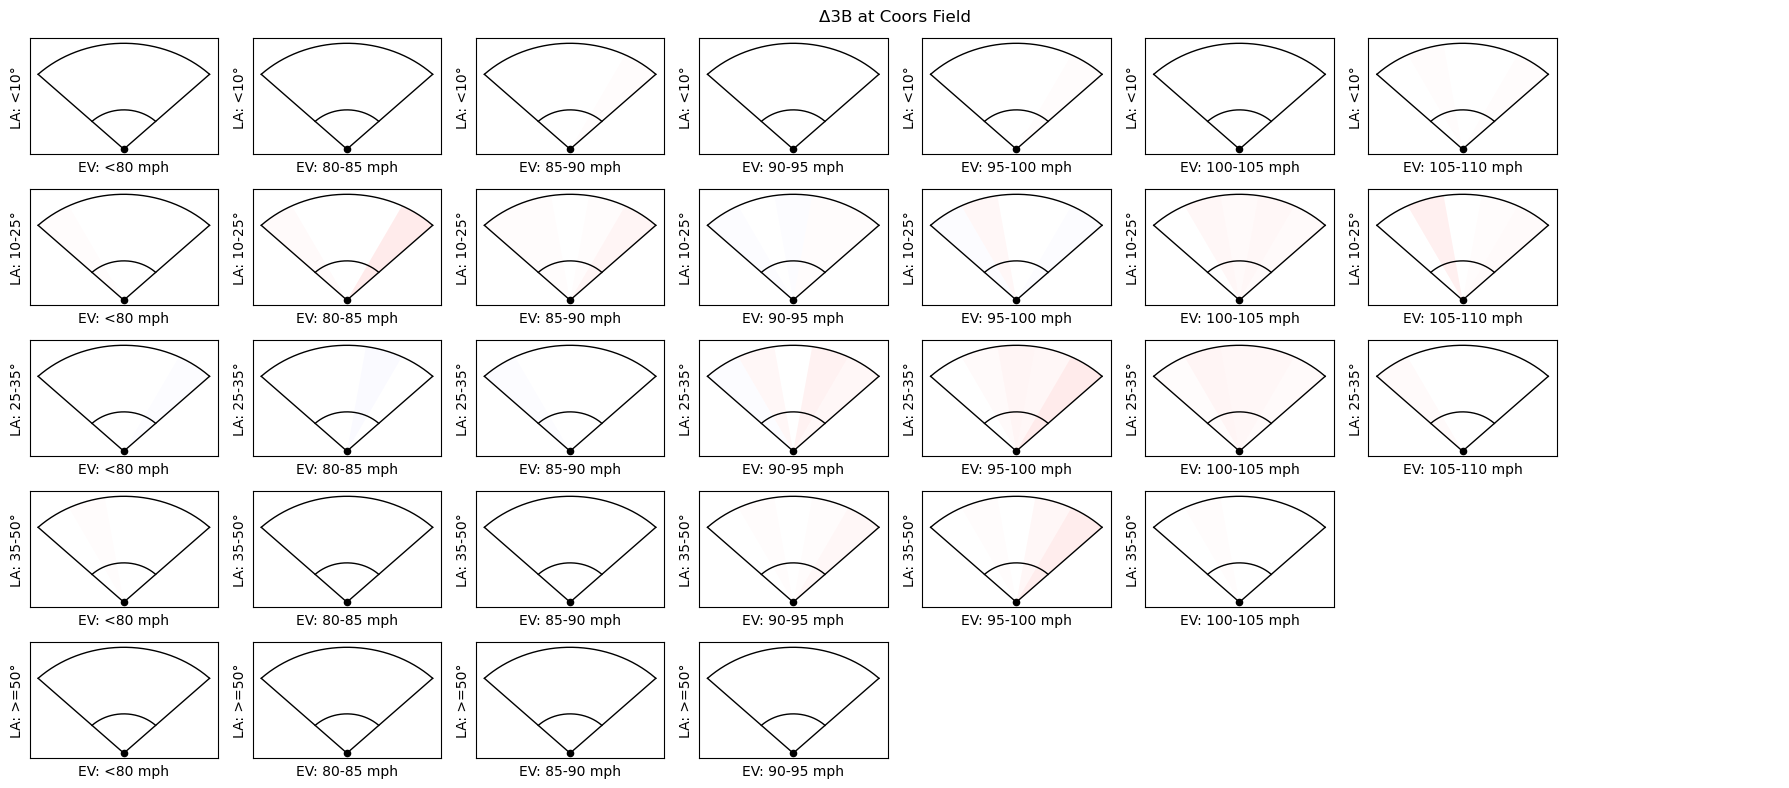

In [11]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['Δ3B'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB)

fig.suptitle('Δ3B at Coors Field')
fig.tight_layout()
plt.show()

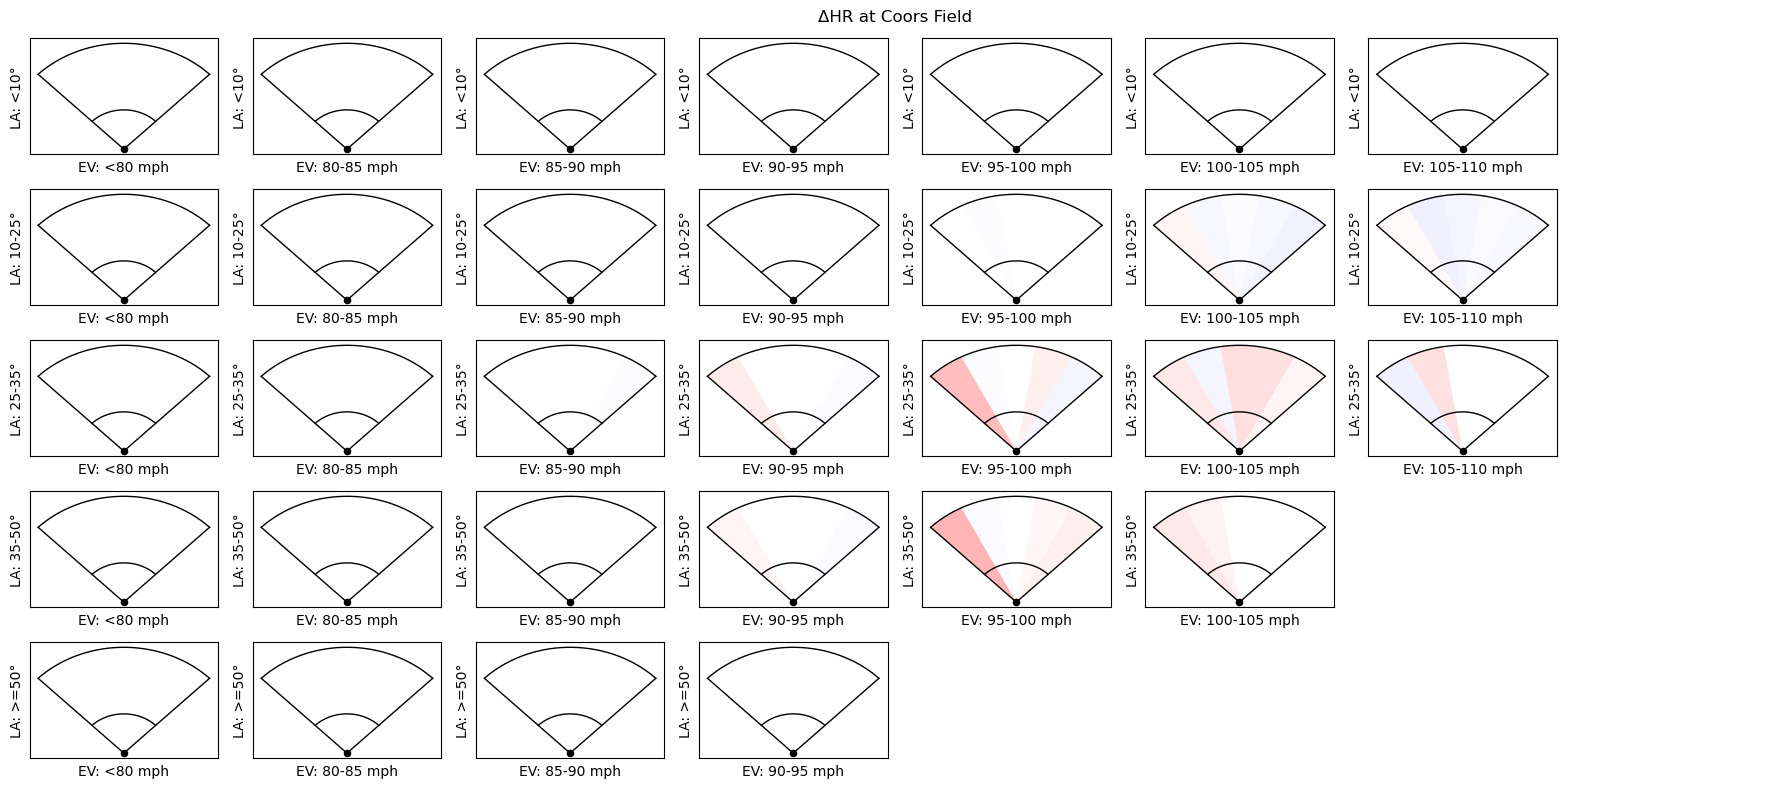

In [12]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['ΔHR'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB)

fig.suptitle('ΔHR at Coors Field')
fig.tight_layout()
plt.show()

## Other stadiums

In [24]:
# Build expected outcomes table
HOME_TEAM = 'LAD'

exp_outcomes = pd.DataFrame(columns=['EV', 'LA', 'SA', 'ΔHR', 'Δ3B', 'Δ2B', 'Δ1B', 'ΔOut', 'Bases_nHome', 'Bases_Home', 'n_Home'])

# Check for valid events
valid_events = [
    'home_run', 'triple', 'double', 'single',
    'field_out', 'sac_fly', 'force_out',
    'double_play', 'grounded_into_double_play',
    'fielders_choice_out', 'fielders_choice',
    'triple_play', 'sac_fly_double_play'
]
df = df.loc[df['events'].isin(valid_events)]

# Iterate through bin type combinations
for ev_bin, la_bin, sa_bin in itertools.product(ev_labels, la_labels, sa_labels):

    # Filter by bin types
    bin_df = df.loc[df['launch_speed_bin'] == ev_bin]
    bin_df = bin_df.loc[bin_df['launch_angle_bin'] == la_bin]
    bin_df = bin_df.loc[bin_df['spray_angle_bin'] == sa_bin]

    # Split by location
    c_bin_df = bin_df.loc[bin_df['home_team'] == HOME_TEAM]
    nc_bin_df = bin_df.loc[bin_df['home_team'] != HOME_TEAM]

    # Iterate through outcomes and compute deltas for hits
    nc = []
    c = []
    deltas = []
    for event in ['home_run', 'triple', 'double', 'single', 'out']:

        # Get event occurance
        if event == 'out':
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'].isin(['field_out', 'sac_fly', 'force_out', 'double_play', 'grounded_into_double_play', 'fielders_choice_out', 'fielders_choice', 'triple_play', 'sac_fly_double_play'])].shape[0]
        else:
            nc_n_event = nc_bin_df.loc[nc_bin_df['events'] == event].shape[0]
            c_n_event = c_bin_df.loc[c_bin_df['events'] == event].shape[0]

        # Convert to probabilities
        try:
            nc_p_event = nc_n_event / nc_bin_df.shape[0]
            c_p_event = c_n_event / c_bin_df.shape[0]
        except ZeroDivisionError:
            deltas.append(np.nan)
            nc.append(np.nan)
            c.append(np.nan)
            continue

        # Compute delta probabilities
        d_p_event = c_p_event - nc_p_event
        deltas.append(d_p_event)
        nc.append(nc_p_event)
        c.append(c_p_event)

    nc_bases = 4 * nc[0] + 3 * nc[1] + 2 * nc[2] + nc[1]
    c_bases = 4 * c[0] + 3 * c[1] + 2 * c[2] + c[1]
    exp_outcomes.loc[exp_outcomes.shape[0]] = [ev_bin, la_bin, sa_bin]  + deltas + [nc_bases, c_bases] + [c_bin_df.shape[0]]

# Drop NA
exp_outcomes.dropna(inplace=True)

# Drop anywhere n_Coors < 50
exp_outcomes = exp_outcomes.loc[exp_outcomes['n_Home'] >= 50]

# Add delta bases
d_bases = 4 * exp_outcomes['ΔHR'] + 3 * exp_outcomes['Δ3B'] + 2 * exp_outcomes['Δ2B'] + exp_outcomes['Δ1B']
exp_outcomes.insert(10, 'ΔBases', d_bases)

# Round 
exp_outcomes = exp_outcomes.round(2)

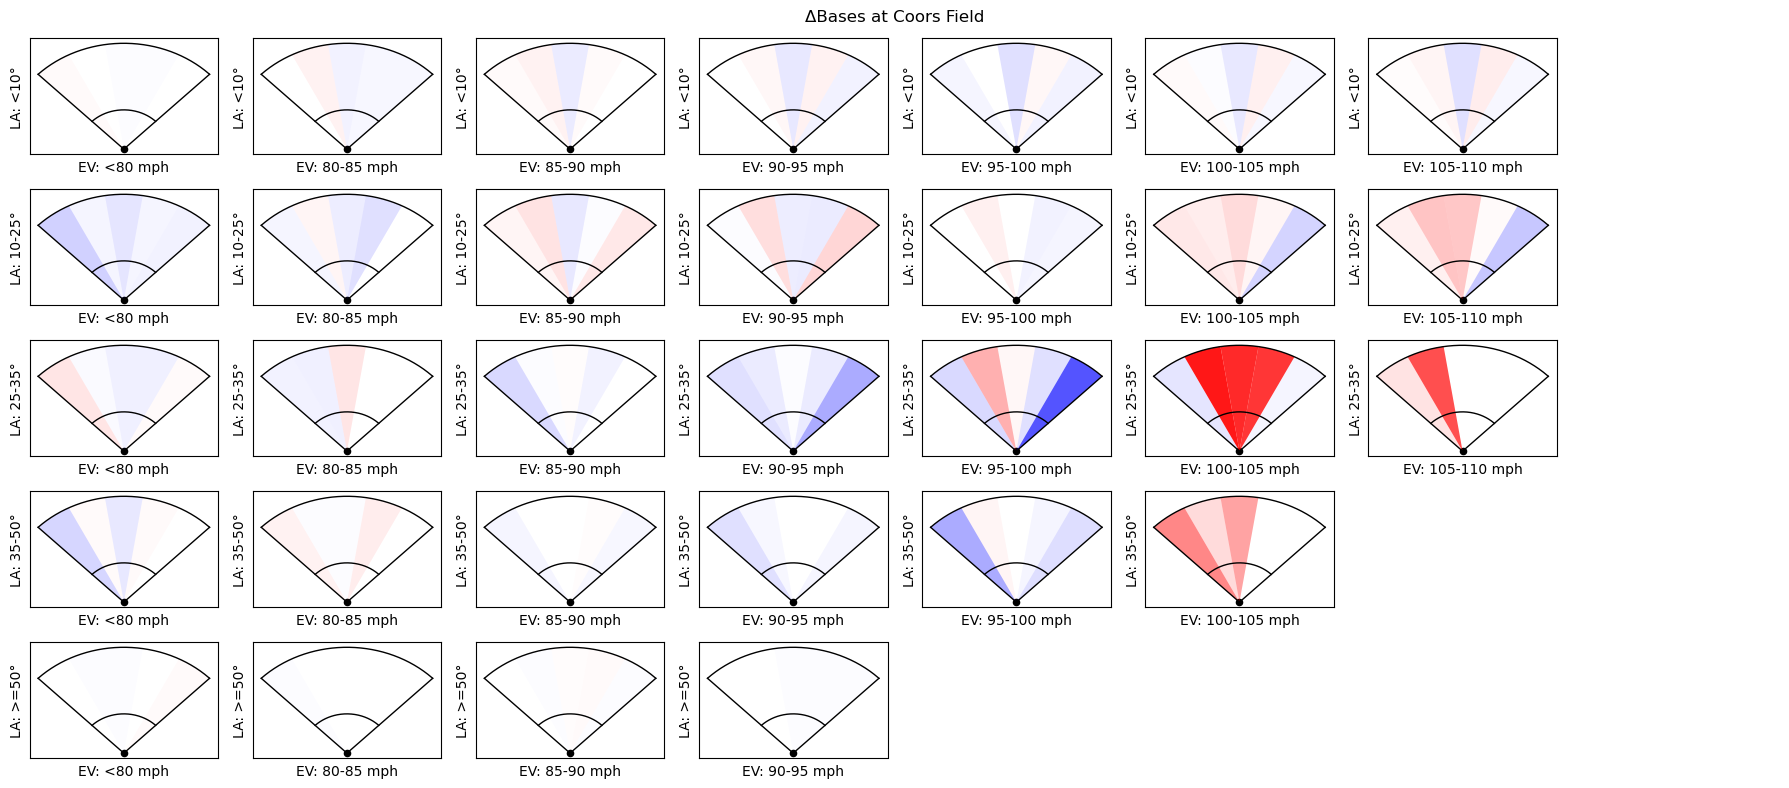

In [25]:
fig, axs = plt.subplots(5, 8, figsize=(18,8))

for i, ev_label in enumerate(ev_labels):
    for j, la_label in enumerate(la_labels):

        # General Plot
        ax = axs[j,i]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(f'LA: {la_label}')
        ax.set_xlabel(f'EV: {ev_label} mph')

        # Get subset
        sub_df = exp_outcomes.loc[exp_outcomes['EV'] == ev_label].loc[exp_outcomes['LA'] == la_label]
        if sub_df.shape[0] == 0:
            ax.axis('off')
            continue
        else:
            draw_field(ax)

        # Add wedges
        for dB, range in zip(sub_df['ΔBases'], [(-45,-27), (-27,-9), (-9,9), (9,27), (27,45)]):
            ax = draw_wedge(ax, range, val=dB, norm_factor=max(np.abs(exp_outcomes['ΔBases']).max(), 1))

fig.suptitle('ΔBases at Coors Field')
fig.tight_layout()
plt.show()